# 解析方針

- 20171014の解析結果から，冷却ペーシング時でもAPVの偏りは存在

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import copy
from scipy import ndimage
import glob
%matplotlib inline

In [2]:
from opmap.RawCam import RawCam
from opmap.VmemMap import VmemMap
from opmap.PhaseMap import PhaseMap
from opmap.PhaseVarianceMap import PhaseVarianceMap
from opmap.APDMap import APDMap

# 2006-02-17/C001S0007の解析

In [7]:
threshold = 0.4

cam = RawCam(path='/mnt/recordings/ExperimentData/2006-02-17/C001S0007/',
                 cam_type='sa4',
                 image_width=256, image_height=256,
                 frame_start=0, frame_end=-1)
cam.setIntROI(val_min=100)

vmem = VmemMap(cam)
vmem.smooth(size=20)

pmap = PhaseMap(vmem, shrink=2)

pvmap = PhaseVarianceMap(pmap, size=3)

APV_array = np.zeros((128, 128))
phase_variance_array = copy.deepcopy(pvmap.data)
ROI = copy.deepcopy(pvmap.roi)
core = (phase_variance_array > threshold) * 1
core_count = np.sum(core, axis=0)

for i in range(128):
    for j in range(128):
        if ROI[i,j] != 0:
            data = copy.deepcopy(phase_variance_array[:, i, j])
            time = data.shape[0]
            while np.max(data) > threshold:
                x_pos = np.argmax(data)
                x_max = x_pos + 1
                x_min = x_pos - 1
                while x_max < time and data[x_max - 1] > data[x_max]:
                    x_max += 1
                while x_min > -1 and data[x_min] < data[x_min + 1]:
                    x_min -= 1
                data[x_min+2:x_max] = 0
            APV_array[i,j] = np.sum(data)/len(np.nonzero(data)[0])

In [28]:
import cv2

raw = cv2.resize(cam.data[0], (128, 128))
raw = raw/np.max(raw)
plt.imshow(APV_array, cmap='jet', alpha=0.7)
plt.colorbar()
plt.imshow(raw, cmap='gray', alpha=0.8)
plt.savefig('/mnt/recordings/AnalysisResult/Seno/opmap/HRS2018/20171016/2006-02-17/C001S0007/APV_cam.png', dpi=300, transparent=True)
plt.close()

## APD計算

In [45]:
APD = APDMap(vmem)

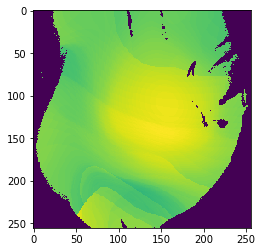

In [47]:
plt.imshow(APD.data[1000])